In [1]:
import os
import copy
import torch
import random
import torchvision
import numpy as np
import torch.nn as nn
from torch.nn import Parameter
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import ConcatDataset
from torch.nn.init import kaiming_normal, calculate_gain
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

from model import *

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']= '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    use_gpu = torch.cuda.is_available()
    n_gpu = torch.cuda.device_count()
    print(f"GPU 数量: {n_gpu}")
print(f"运行平台: {device}")

GPU 数量: 1
运行平台: cuda


In [3]:
classes = ["parallel","clinoform","fill","hummocky","chaotic"]
nums = [2000,1500,1500,1500,1500]

sample_total_train = {"parallel":None,"clinoform":None,
                      "fill":None,"hummocky":None,"chaotic":None}
sample_total_valid = {"parallel":None,"clinoform":None,
                      "fill":None,"hummocky":None,"chaotic":None}

for ip in range(5):
    class_name = classes[ip]
    num_sample = nums[ip]
    root_path = os.path.abspath('..')
    dataset_path = os.path.join(root_path, "datasets", class_name + "_classification")
    sample_name_list = []
    for i in range(num_sample):
        train_sample_file = f'{i}'
        sample_name_list.append(train_sample_file)
    # 混乱数据集
    random.shuffle(sample_name_list)
    num_data_sample = len(sample_name_list)
    # 训练集/验证集划分
    train_valid_ratio = 0.7999
    valid_num = int(num_data_sample * (1-train_valid_ratio))
    valid_list = random.sample(sample_name_list, valid_num)
    
    samples_train,samples_valid = [],[]
    for sample_name in sample_name_list[:num_sample]:
        if sample_name not in valid_list:
            samples_train.append(sample_name)
        else:
            samples_valid.append(sample_name)
    print(f'{class_name} 训练、验证样本数量：{len(samples_train)}, {len(samples_valid)}')
    sample_total_train[class_name] = samples_train
    sample_total_valid[class_name] = samples_valid

samples_file = os.path.join(os.path.join(root_path, "datasets"))
# np.save(os.path.join(samples_file,"samples_classification_train.npy"), sample_total_train)
# np.save(os.path.join(samples_file,"samples_classification_valid.npy"), sample_total_valid)

parallel 训练、验证样本数量：1600, 400
clinoform 训练、验证样本数量：1200, 300
fill 训练、验证样本数量：1200, 300
hummocky 训练、验证样本数量：1200, 300
chaotic 训练、验证样本数量：1200, 300


In [4]:
class build_dataset_classification(Dataset):
    def __init__(self, samples_list, samples_file,class_name):
        self.samples_list = samples_list
        self.dataset_path = os.path.join(samples_file, class_name + "_classification")
        self.class_name = class_name
        
    def __len__(self):
        return len(self.samples_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        classes = ["parallel","clinoform","fill","hummocky","chaotic"]
        sample_file_name = self.samples_list[idx]
        sample_file_path = os.path.join(self.dataset_path, sample_file_name + ".dat")
        sample = np.fromfile(sample_file_path, dtype=np.int32).reshape(128,128).T
#         sample = np.where(sample==0,-1,sample)
        sample = sample[np.newaxis,:,:]
        label = np.eye(5)[classes.index(self.class_name)]
        
        return  [sample,label]

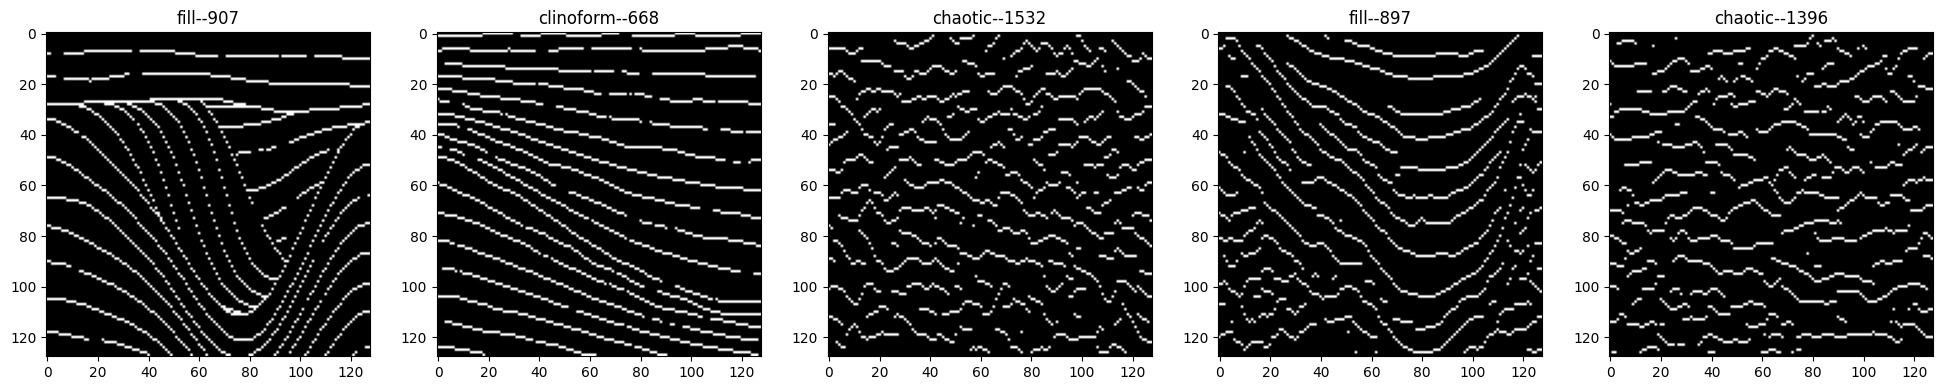

In [5]:
# visual
root_path = os.path.abspath('..')
samples_file = os.path.join(os.path.join(root_path, "datasets"))
dataset_path = os.path.join(root_path, "datasets", class_name + "_classification")
sample_total_valid = np.load(os.path.join(samples_file, "samples_classification_valid.npy"), allow_pickle=True).item()

# build datasets
classes = ["parallel","clinoform","fill","hummocky","chaotic"]
for ip in range(5):
    if ip==0:
        class_name = classes[ip]
        # validation
        samples_list_valid = sample_total_valid[class_name]
        samples_valid_total = build_dataset_classification(samples_list_valid,samples_file,class_name)
    else:
        class_name = classes[ip]
        # validation
        samples_list_valid = sample_total_valid[class_name]
        samples_valid = build_dataset_classification(samples_list_valid,samples_file,class_name)
        samples_valid_total = samples_valid_total + samples_valid
    
idxs = np.random.randint(0, len(samples_valid_total), size=5) 
batch_samples = [samples_valid_total[i] for i in idxs]
plt.figure(figsize=(20,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(batch_samples[i][0].squeeze(),cmap="gray")
    plt.title(str(classes[np.argwhere(batch_samples[i][1]==1)[0][0]])+"--"+str(idxs[i]))
    plt.tight_layout()

In [6]:
# load datasets
image_size = [1, 128, 128]
batch_size = 16

root_path = os.path.abspath('..')
samples_file = os.path.join(os.path.join(root_path, "datasets"))
dataset_path = os.path.join(root_path, "datasets", class_name + "_classification")
sample_total_valid = np.load(os.path.join(samples_file, "samples_classification_valid.npy"), allow_pickle=True).item()

# build datasets
classes = ["parallel","clinoform","fill","hummocky","chaotic"]
for ip in range(5):
    if ip==0:
        class_name = classes[ip]
        # validation
        samples_list_valid = sample_total_valid[class_name]
        samples_valid_total = build_dataset_classification(samples_list_valid,samples_file,class_name)
    else:
        class_name = classes[ip]
        # validation
        samples_list_valid = sample_total_valid[class_name]
        samples_valid = build_dataset_classification(samples_list_valid,samples_file,class_name)
        samples_valid_total = samples_valid_total + samples_valid

valid_loader = DataLoader(samples_valid_total, batch_size=1, shuffle=False)

In [7]:
model = resnet50(num_classes=5)
model.load_state_dict(torch.load("./Network_path/classification_DDE_agument/checkpoint-best.pth")['state_dict'])

<All keys matched successfully>

In [8]:
valid_loader = DataLoader(samples_valid_total, batch_size=1, shuffle=False)
pred_samples = []

# validation
model.eval()
loss_valid_per_epoch = 0
with torch.no_grad():
    for i, mini_batch in enumerate(valid_loader):
        batch_samples = {}
        data = torch.tensor(mini_batch[0],dtype=torch.float32)
        label = torch.tensor(mini_batch[1],dtype=torch.float32)
        if use_gpu:
            data = Variable(data)
            label = Variable(label)
        pred = model(data)
        pred = F.softmax(pred,dim=1)
        pred = torch.argmax(pred,dim=1,keepdim=True)
        label = torch.argmax(label,dim=1,keepdim=True)
        print("pred & label --> ",pred,label)
        batch_samples["data"] = data[0].cpu().numpy().squeeze(0)
        batch_samples["label"] = label[0].cpu().numpy().squeeze(0)
        batch_samples["pred"] = pred[0].cpu().numpy().squeeze(0)

        pred_samples.append(batch_samples)
print("Finished")

pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) te

pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[1]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) te

pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) te

pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[0]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) te

pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) te

pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) te

pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) te

pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) te

pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[1]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) te

In [9]:
np.save("./valid_pred_agument.npy", pred_samples)

[189, 1402, 1382, 154, 1522, 1315, 1083, 513, 324, 1405]


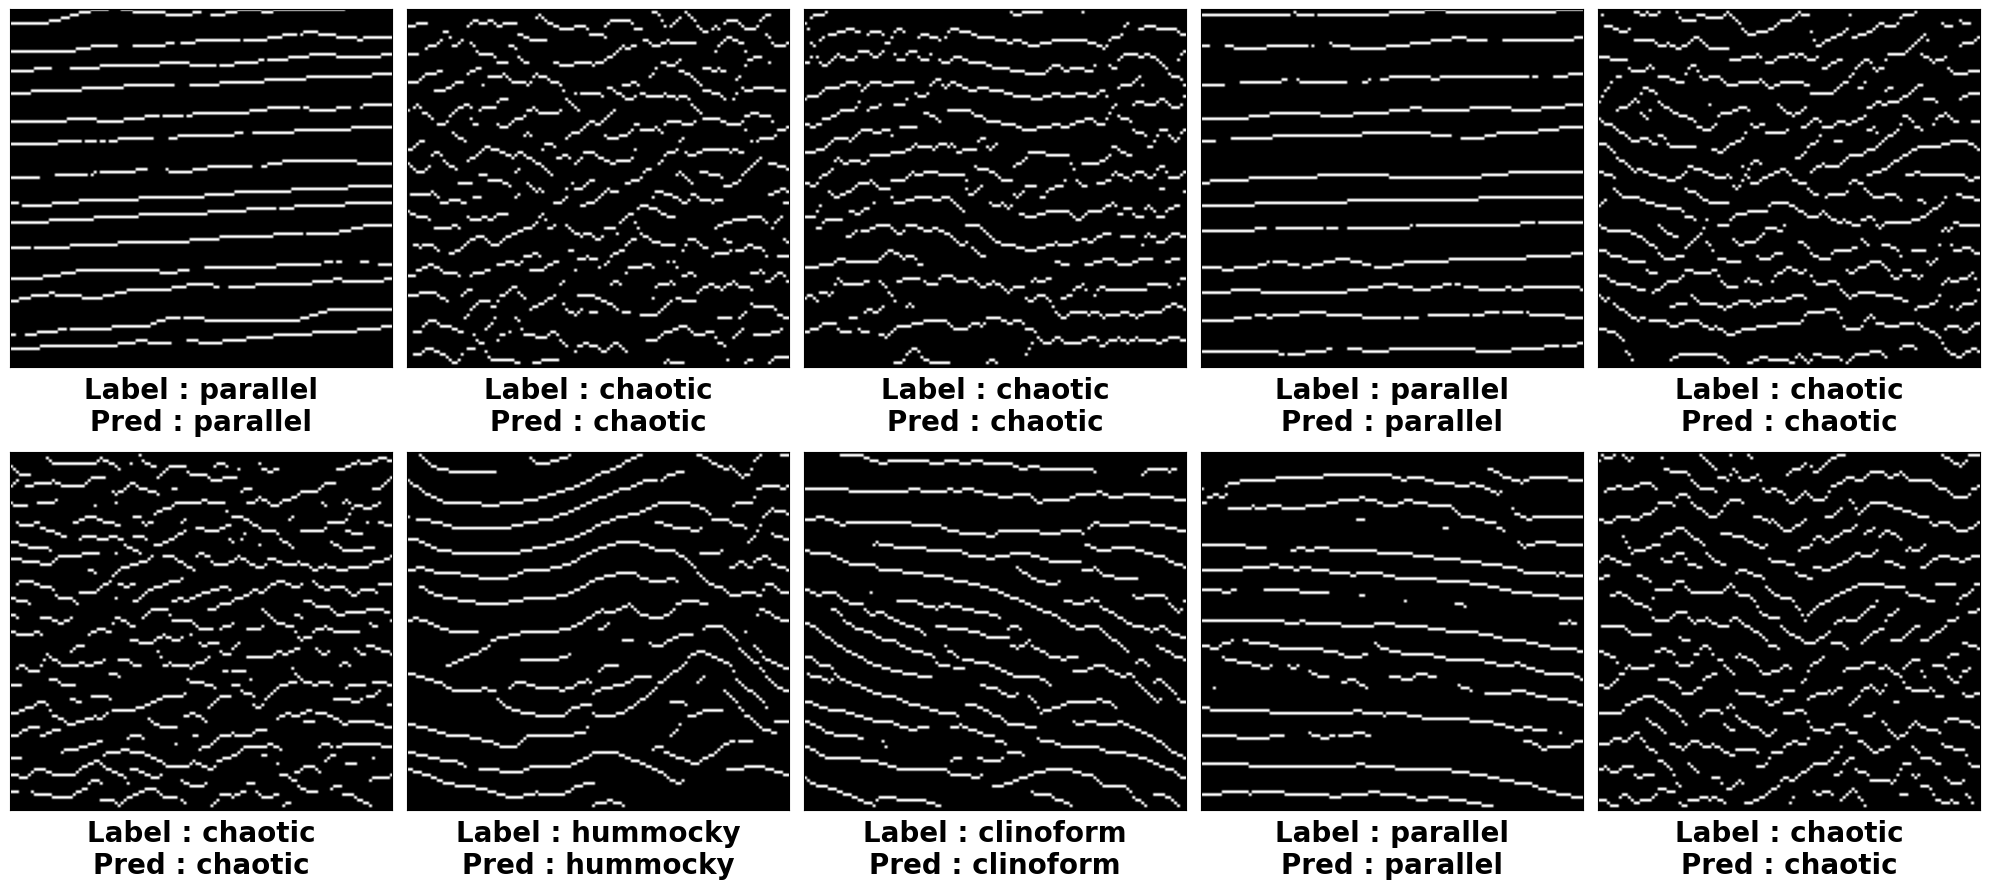

In [10]:
num1,num2 = 5,2
plt.figure(figsize=(4*num1,4.5*num2))
indx = random.sample(range(0,len(pred_samples)),num1*num2)
classes = ["parallel","clinoform","fill","hummocky","chaotic"]
print(indx)
for i in range(num1*num2):
    ind = indx[i]
    plt.subplot(num2,num1,i+1)
    plt.imshow(pred_samples[ind]["data"],cmap="gray",aspect="auto")
    plt.xticks([]),plt.yticks([])
    plt.title("Label : "+ classes[int(pred_samples[ind]["label"])] +
              "\n" "Pred : "+ classes[int(pred_samples[ind]["pred"])],
              fontsize=20, y=-0.2,fontweight='bold')
    plt.tight_layout()

In [11]:
len(pred_samples)

1600

[60, 460, 760, 1060, 1360, 50, 450, 750, 1050, 1350]


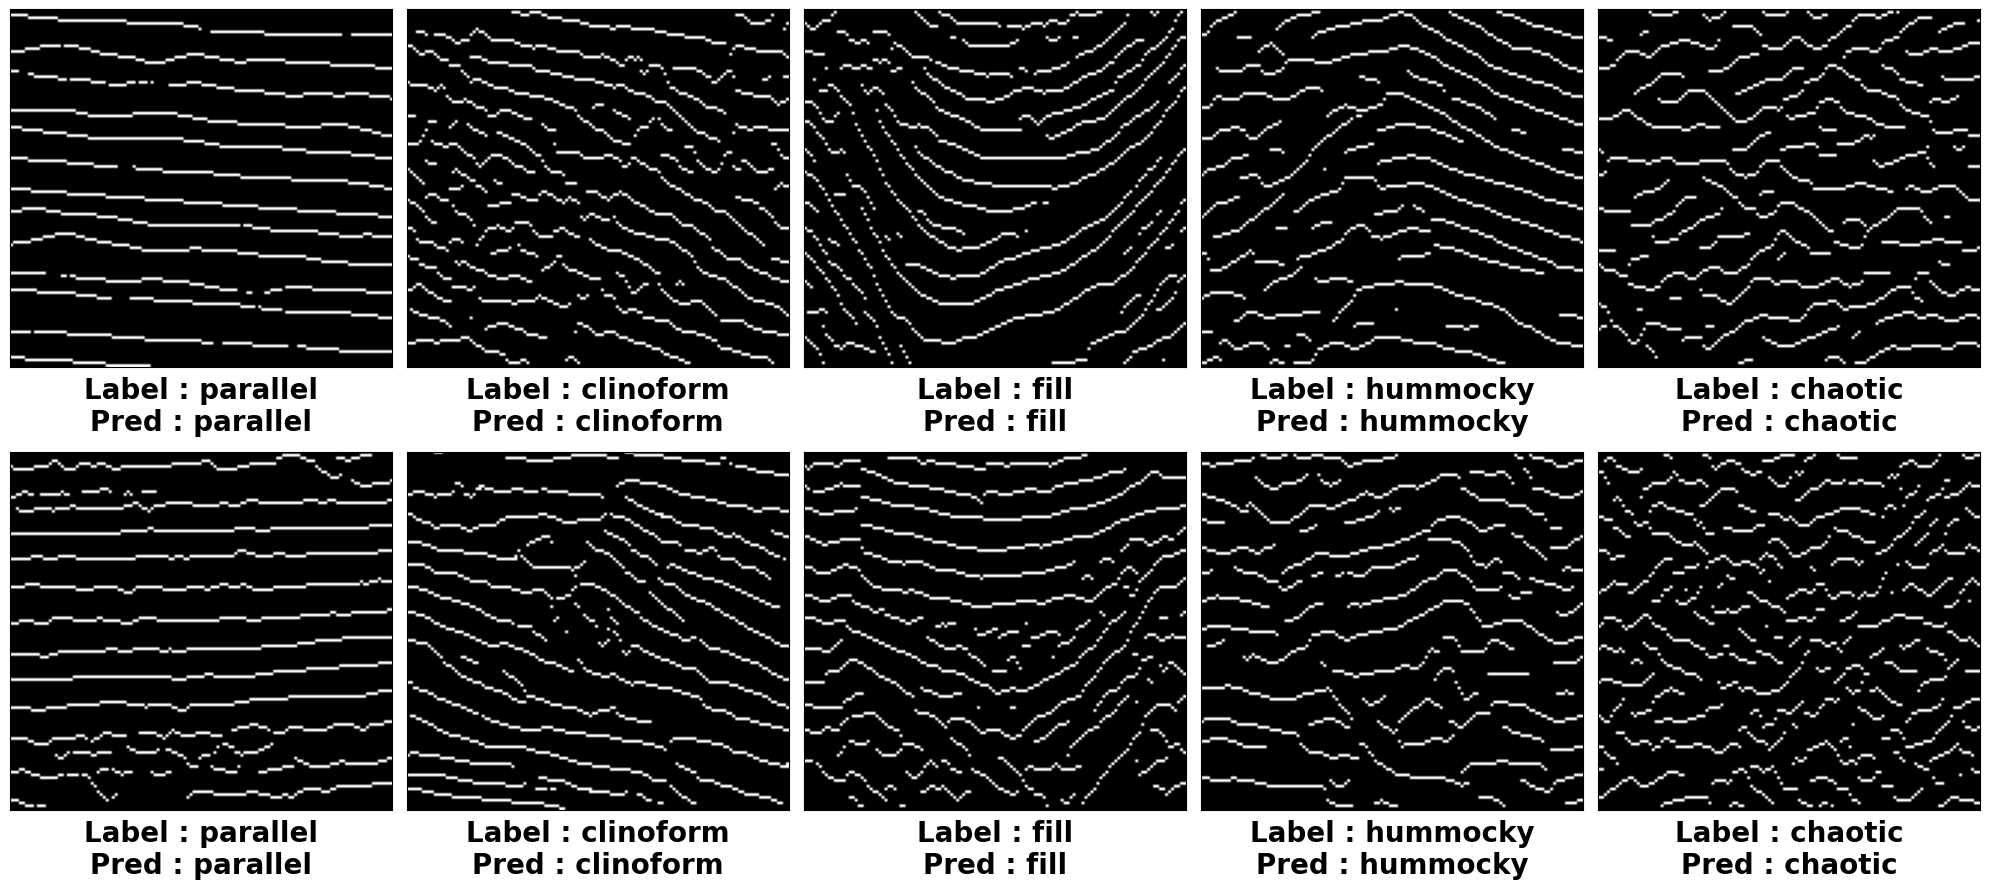

In [21]:
num1,num2 = 5,2
plt.figure(figsize=(4*num1,4.5*num2))
indx = random.sample(range(0,len(pred_samples)),num1*num2)
i0,i1 = 60,50
indx = [i0,400+i0,700+i0,1000+i0,1300+i0,i1,400+i1,700+i1,1000+i1,1300+i1]


classes = ["parallel","clinoform","fill","hummocky","chaotic"]
print(indx)
for i in range(num1*num2):
    ind = indx[i]
    plt.subplot(num2,num1,i+1)
    plt.imshow(pred_samples[ind]["data"],cmap="gray",aspect="auto")
    plt.xticks([]),plt.yticks([])
    plt.title("Label : "+ classes[int(pred_samples[ind]["label"])] +
              "\n" "Pred : "+ classes[int(pred_samples[ind]["pred"])],
              fontsize=20, y=-0.2,fontweight='bold')
    plt.tight_layout()

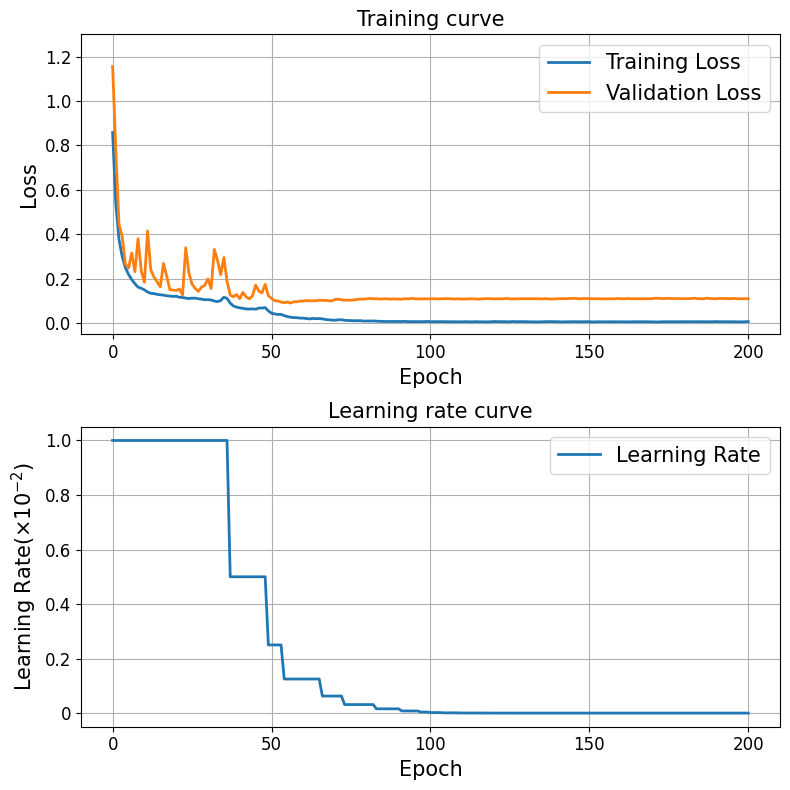

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def smooth(v, w=0.85):
    last = v[0]
    smoothed = []
    for point in v:
        smoothed_val = last * w + (1 - w) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed  


logs = np.load("./Network_path/classification_DDE_agument/logs.npy",allow_pickle=True)
# print(logs.item())

tr = logs.item()['epoch_loss_train']
va = logs.item()['epoch_loss_valid']
lr = logs.item()['epoch_lr']

x = [i for i in range(201)]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(2, 1, 1)
ax.plot(x, smooth(tr, 0.4), label='Training Loss', linewidth=2)
ax.plot(x, smooth(va, 0.4), label='Validation Loss',linewidth=2)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_title(f'Training curve', fontsize=15)
ax.grid(True)
plt.ylim(-0.05,1.3)
plt.xticks([0,50,100,150,200],fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=15)
plt.tight_layout()

ax = fig.add_subplot(2, 1, 2)
ax.plot(x, lr, label='Learning Rate', linewidth=2)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel('Learning Rate($\\times 10^{-2}$)', fontsize=15)
ax.set_title(f'Learning rate curve', fontsize=15)
ax.grid(True)
# plt.ylim(-0.05,1.3)
plt.xticks([0,50,100,150,200],fontsize=12)
plt.yticks([0,0.002,0.004,0.006,0.008,0.01],[0,0.2,0.4,0.6,0.8,1.0],fontsize=12)
plt.legend(loc='upper right', fontsize=15)
plt.tight_layout()
plt.show()

In [27]:
len(tr)

201

# testing accuracy

In [1]:
import os
import copy
import torch
import random
import torchvision
import numpy as np
import torch.nn as nn
from torch.nn import Parameter
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import ConcatDataset
from torch.nn.init import kaiming_normal, calculate_gain
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

from model import *

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']= '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    use_gpu = torch.cuda.is_available()
    n_gpu = torch.cuda.device_count()
    print(f"GPU 数量: {n_gpu}")
print(f"运行平台: {device}")

GPU 数量: 1
运行平台: cuda


In [7]:
classes = ["parallel","clinoform","fill","hummocky","chaotic"]
nums = [2000,1500,1500,1500,1500]

sample_total_train = {"parallel":None,"clinoform":None,
                      "fill":None,"hummocky":None,"chaotic":None}
sample_total_valid = {"parallel":None,"clinoform":None,
                      "fill":None,"hummocky":None,"chaotic":None}

for ip in range(5):
    class_name = classes[ip]
    num_sample = nums[ip]
    root_path = os.path.abspath('..')
    dataset_path = os.path.join(root_path, "datasets", class_name + "_classification")
    sample_name_list = []
    for i in range(num_sample):
        train_sample_file = f'{i}'
        sample_name_list.append(train_sample_file)
    # 混乱数据集
    random.shuffle(sample_name_list)
    num_data_sample = len(sample_name_list)
    # 训练集/验证集划分
    train_valid_ratio = 0.7999
    valid_num = int(num_data_sample * (1-train_valid_ratio))
    valid_list = random.sample(sample_name_list, valid_num)
    
    samples_train,samples_valid = [],[]
    for sample_name in sample_name_list[:num_sample]:
        if sample_name not in valid_list:
            samples_train.append(sample_name)
        else:
            samples_valid.append(sample_name)
    print(f'{class_name} 训练、验证样本数量：{len(samples_train)}, {len(samples_valid)}')
    sample_total_train[class_name] = samples_train
    sample_total_valid[class_name] = samples_valid

samples_file = os.path.join(os.path.join(root_path, "datasets"))
# np.save(os.path.join(samples_file,"samples_classification_train.npy"), sample_total_train)
# np.save(os.path.join(samples_file,"samples_classification_valid.npy"), sample_total_valid)

parallel 训练、验证样本数量：1600, 400
clinoform 训练、验证样本数量：1200, 300
fill 训练、验证样本数量：1200, 300
hummocky 训练、验证样本数量：1200, 300
chaotic 训练、验证样本数量：1200, 300


In [3]:
class build_dataset_classification(Dataset):
    def __init__(self, samples_list, samples_file,class_name):
        self.samples_list = samples_list
        self.dataset_path = os.path.join(samples_file, class_name + "_classification")
        self.class_name = class_name
        
    def __len__(self):
        return len(self.samples_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        classes = ["parallel","clinoform","fill","hummocky","chaotic"]
        sample_file_name = self.samples_list[idx]
        sample_file_path = os.path.join(self.dataset_path, sample_file_name + ".dat")
        sample = np.fromfile(sample_file_path, dtype=np.int32).reshape(128,128).T
#         sample = np.where(sample==0,-1,sample)
        sample = sample[np.newaxis,:,:]
        label = np.eye(5)[classes.index(self.class_name)]
        
        return  [sample,label]

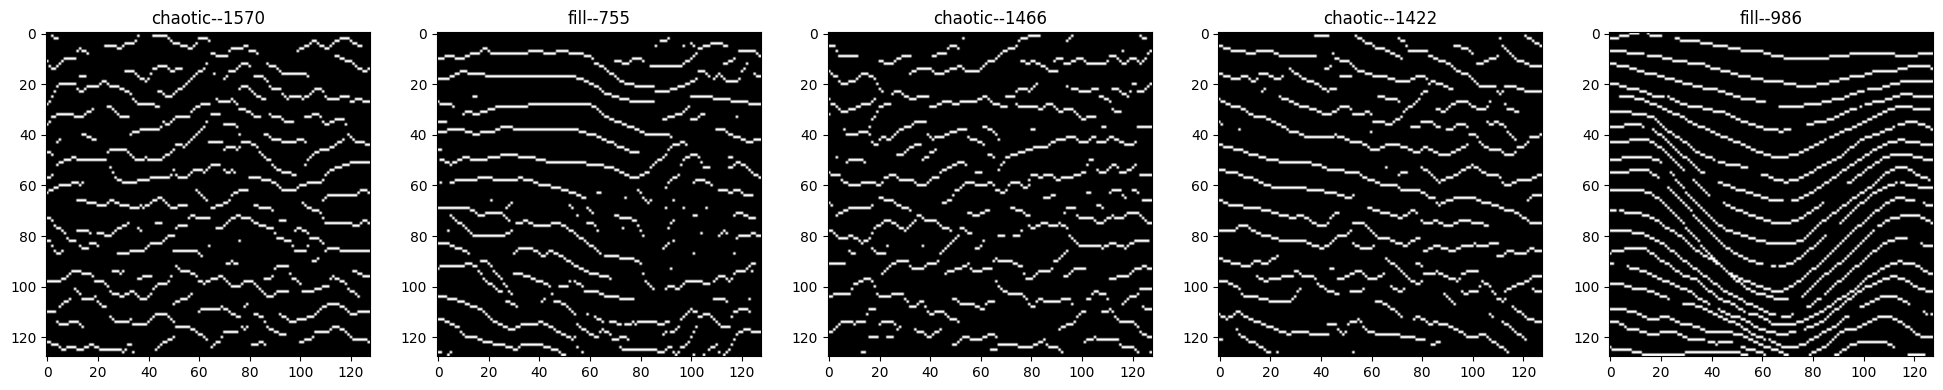

In [8]:
# visual
root_path = os.path.abspath('..')
samples_file = os.path.join(os.path.join(root_path, "datasets"))
dataset_path = os.path.join(root_path, "datasets", class_name + "_classification")
sample_total_valid = np.load(os.path.join(samples_file, "samples_classification_valid.npy"), allow_pickle=True).item()

# build datasets
classes = ["parallel","clinoform","fill","hummocky","chaotic"]
for ip in range(5):
    if ip==0:
        class_name = classes[ip]
        # validation
        samples_list_valid = sample_total_valid[class_name]
        samples_valid_total = build_dataset_classification(samples_list_valid,samples_file,class_name)
    else:
        class_name = classes[ip]
        # validation
        samples_list_valid = sample_total_valid[class_name]
        samples_valid = build_dataset_classification(samples_list_valid,samples_file,class_name)
        samples_valid_total = samples_valid_total + samples_valid
    
idxs = np.random.randint(0, len(samples_valid_total), size=5) 
batch_samples = [samples_valid_total[i] for i in idxs]
plt.figure(figsize=(20,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(batch_samples[i][0].squeeze(),cmap="gray")
    plt.title(str(classes[np.argwhere(batch_samples[i][1]==1)[0][0]])+"--"+str(idxs[i]))
    plt.tight_layout()

In [9]:
# load datasets
image_size = [1, 128, 128]
batch_size = 16

root_path = os.path.abspath('..')
samples_file = os.path.join(os.path.join(root_path, "datasets"))
dataset_path = os.path.join(root_path, "datasets", class_name + "_classification")
sample_total_valid = np.load(os.path.join(samples_file, "samples_classification_valid.npy"), allow_pickle=True).item()

# build datasets
classes = ["parallel","clinoform","fill","hummocky","chaotic"]
for ip in range(5):
    if ip==0:
        class_name = classes[ip]
        # validation
        samples_list_valid = sample_total_valid[class_name]
        samples_valid_total = build_dataset_classification(samples_list_valid,samples_file,class_name)
    else:
        class_name = classes[ip]
        # validation
        samples_list_valid = sample_total_valid[class_name]
        samples_valid = build_dataset_classification(samples_list_valid,samples_file,class_name)
        samples_valid_total = samples_valid_total + samples_valid

valid_loader = DataLoader(samples_valid_total, batch_size=1, shuffle=False)

In [11]:
model = resnet50(num_classes=5)
model.load_state_dict(torch.load("./Network_path/classification_DDE_agument/checkpoint-best.pth")['state_dict'])

<All keys matched successfully>

In [12]:
valid_loader = DataLoader(samples_valid_total, batch_size=1, shuffle=False)
pred_samples = []

# validation
model.eval()
loss_valid_per_epoch = 0
with torch.no_grad():
    for i, mini_batch in enumerate(valid_loader):
        batch_samples = {}
        data = torch.tensor(mini_batch[0],dtype=torch.float32)
        label = torch.tensor(mini_batch[1],dtype=torch.float32)
        if use_gpu:
            data = Variable(data)
            label = Variable(label)
        pred = model(data)
        pred = F.softmax(pred,dim=1)
        pred = torch.argmax(pred,dim=1,keepdim=True)
        label = torch.argmax(label,dim=1,keepdim=True)
        print("pred & label --> ",pred,label)
        batch_samples["data"] = data[0].cpu().numpy().squeeze(0)
        batch_samples["label"] = label[0].cpu().numpy().squeeze(0)
        batch_samples["pred"] = pred[0].cpu().numpy().squeeze(0)
        
        pred_samples.append(batch_samples)
print("Finished")

pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) te

pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[1]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) te

pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) tensor([[0]])
pred & label -->  tensor([[0]]) te

pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[0]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) tensor([[1]])
pred & label -->  tensor([[1]]) te

pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) te

pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) tensor([[2]])
pred & label -->  tensor([[2]]) te

pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) te

pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) tensor([[3]])
pred & label -->  tensor([[3]]) te

pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[4]]) tensor([[4]])
pred & label -->  tensor([[1]]) te

In [27]:
x = pred_samples[0]
x

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'label': array(0),
 'pred': array(0)}

In [41]:
p0,p1,p2,p3,p4 = [],[],[],[],[]

for i in range(1600):
    if pred_samples[i]["label"]==0:
        p0.append(pred_samples[i]["pred"])
    elif pred_samples[i]["label"]==1:
        p1.append(pred_samples[i]["pred"])
    elif pred_samples[i]["label"]==2:
        p2.append(pred_samples[i]["pred"])
    elif pred_samples[i]["label"]==3:
        p3.append(pred_samples[i]["pred"])
    elif pred_samples[i]["label"]==4:
        p4.append(pred_samples[i]["pred"])

In [48]:
k = 0
for i in range(len(p0)):
    if p0[i]==0:
        k = k + 1
acc0 = k/len(p0)
acc0

0.9775

In [50]:
k = 0
for i in range(len(p1)):
    if p1[i]==1:
        k = k + 1
acc0 = k/len(p1)
acc0

0.99

In [52]:
k = 0
for i in range(len(p2)):
    if p2[i]==2:
        k = k + 1
acc0 = k/len(p2)
acc0

0.9966666666666667

In [53]:
k = 0
for i in range(len(p3)):
    if p3[i]==3:
        k = k + 1
acc0 = k/len(p3)
acc0

0.9733333333333334

In [54]:
k = 0
for i in range(len(p4)):
    if p4[i]==4:
        k = k + 1
acc0 = k/len(p4)
acc0

0.9833333333333333